# Trying to regress the coordinates

### Initial imports

In [1]:
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Dense, Flatten, Input
from keras.models import Model

from src.experiment.data_loading import (
    load_and_process_coordinates,
    load_image_set,
    prepare_train_val_test_splits,
)
from src.experiment.model_blocks import (
    double_conv_block,
    downsample_block,
    upsample_block_without_skip_connection,
)
from src.experiment.regression_evaluation import (
    flatten_encoded_images,
    get_encoded_images,
    regression_evaluation,
)
from src.experiment.visualization import plot_frames, visualize_layer_outputs

### Loading images

In [2]:
# Dataset dependant parameters
DATA_FOLDER = "data/3ball"
NUM_BALLS = 3
PIXELS_PER_AXIS = 32
COLORED_BALLS = False

X1, X2, Y = load_image_set(data_folder=DATA_FOLDER, colored_balls=COLORED_BALLS)

100%|██████████| 10000/10000 [00:04<00:00, 2041.59it/s]


### Loading coordinates and splitting data

In [3]:
coordinates = load_and_process_coordinates(
    data_folder=DATA_FOLDER, num_balls=NUM_BALLS, pixels_per_axis=PIXELS_PER_AXIS
)

# Prepare train, validation, and test splits
(
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test,
    coordinates_train,
    coordinates_val,
    coordinates_test,
) = prepare_train_val_test_splits(X1, X2, Y, coordinates)

### Model definition and training

In [6]:
# Input layer
inputs = Input(shape=(PIXELS_PER_AXIS, PIXELS_PER_AXIS, 2))

# Encoder layer
_, u1 = downsample_block(input_layer=inputs, n_filters=1)
# Bottleneck layer
bottleneck = double_conv_block(input_layer=u1, n_filters=2)
# Decoder layer
u3 = upsample_block_without_skip_connection(input_layer=bottleneck, n_filters=1)

# Output layer
outputs = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(u3)

model = Model(inputs, outputs, name="Convolutional_Autoencoder")
model.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "Convolutional_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 1)         19        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 1)         10        
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 1)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 1)         10        
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 2)         20        
                                         

In [7]:
model.compile(optimizer="adam", loss="mse")

model.fit(
    x_train,
    y_train,
    epochs=250,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[
        EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True, min_delta=0.001
        )
    ],
)

Epoch 1/250


250/250 [==============================] - 13s 40ms/step - loss: 0.1032 - val_loss: 0.0230
Epoch 2/250
250/250 [==============================] - 8s 32ms/step - loss: 0.0204 - val_loss: 0.0183
Epoch 3/250
250/250 [==============================] - 5s 22ms/step - loss: 0.0173 - val_loss: 0.0163
Epoch 4/250
250/250 [==============================] - 5s 20ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 5/250
250/250 [==============================] - 5s 22ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 6/250
250/250 [==============================] - 5s 21ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 7/250
250/250 [==============================] - 5s 20ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 8/250
250/250 [==============================] - 5s 19ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 9/250
250/250 [==============================] - 5s 19ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 10/250
250/250 [==============================] - 5s 19ms/step - loss: 0.0140 - val_los

### Model reconstructions

We print (from left to right) the 3 frames of the sample (2 inputs and output), an auxiliar image to see of how much movement there is between the first and final frame, the reconstructed image and the 3rd frame over the reconstructed image. This last image is useful to see if the position of the balls is accurately predicted.

32/32 [==============================] - 1s 13ms/step


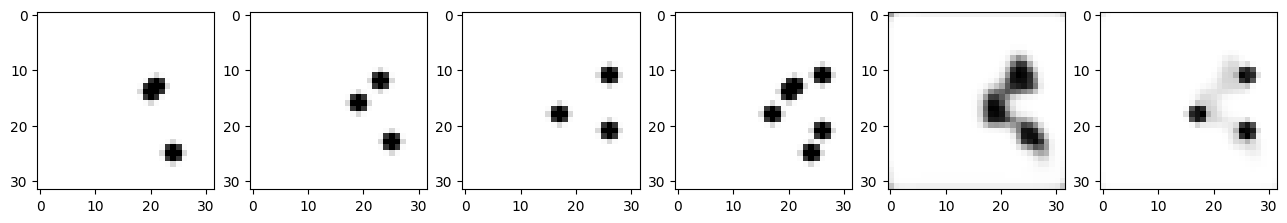

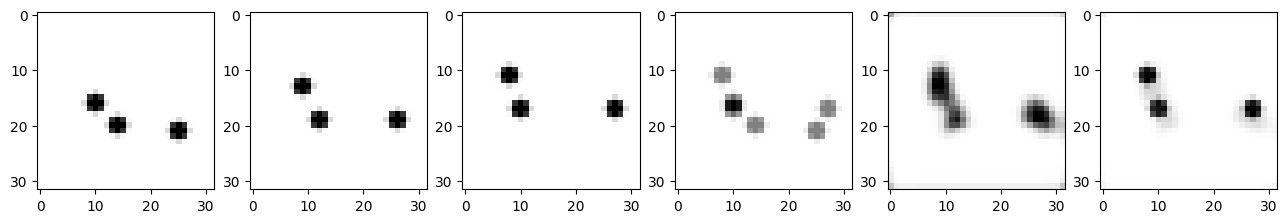

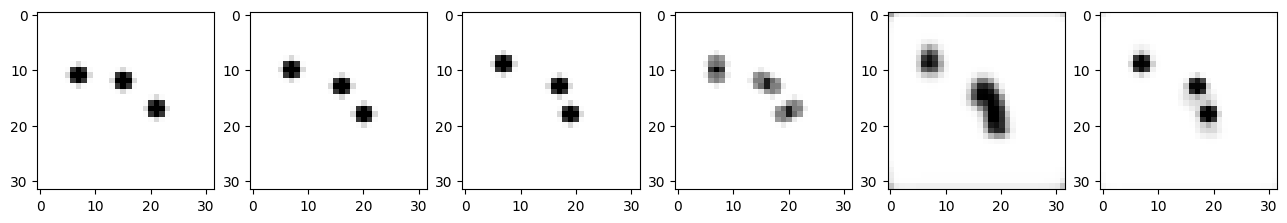

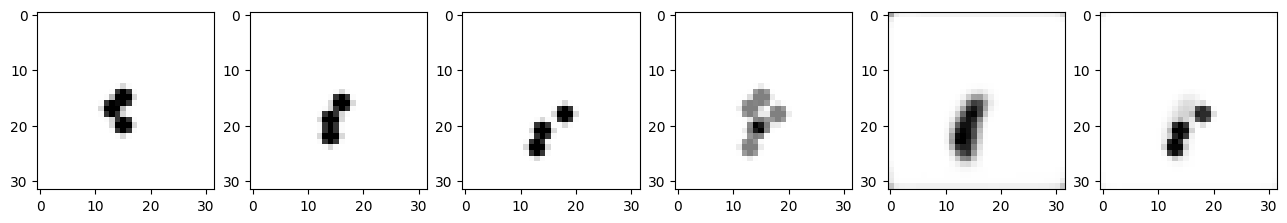

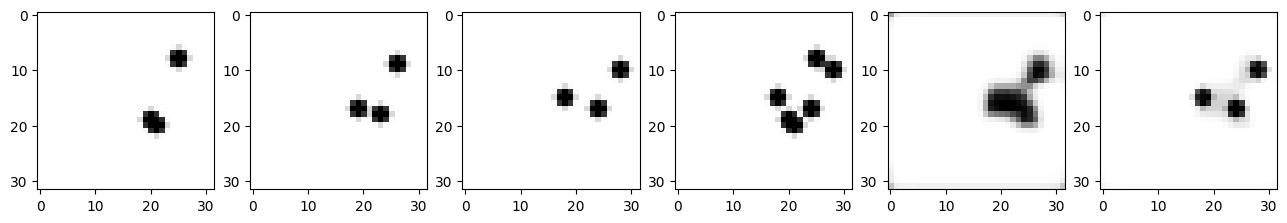

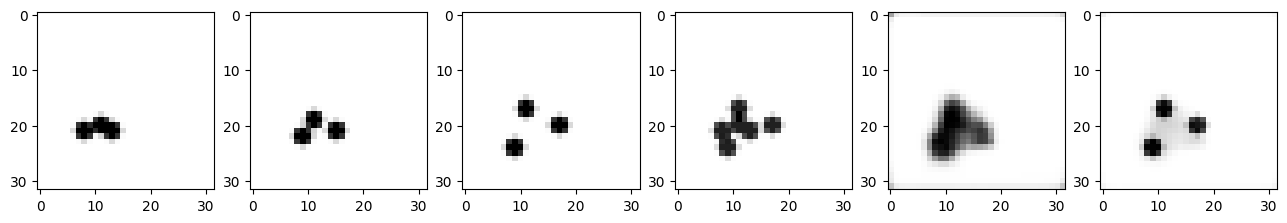

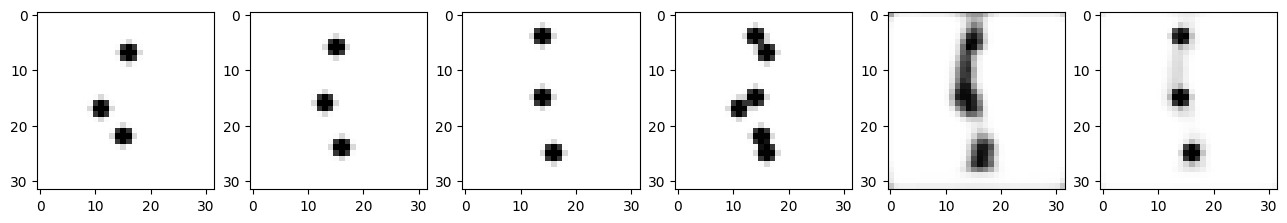

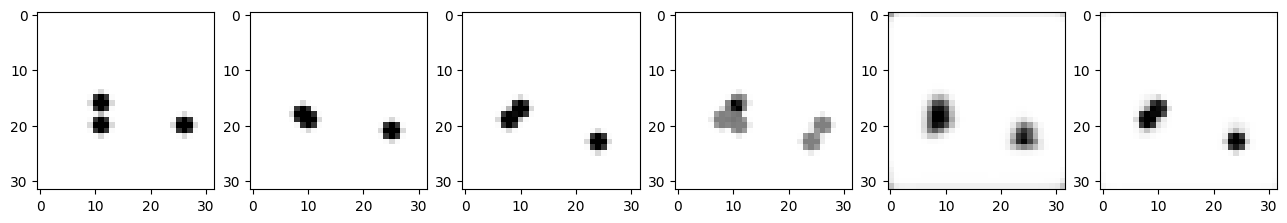

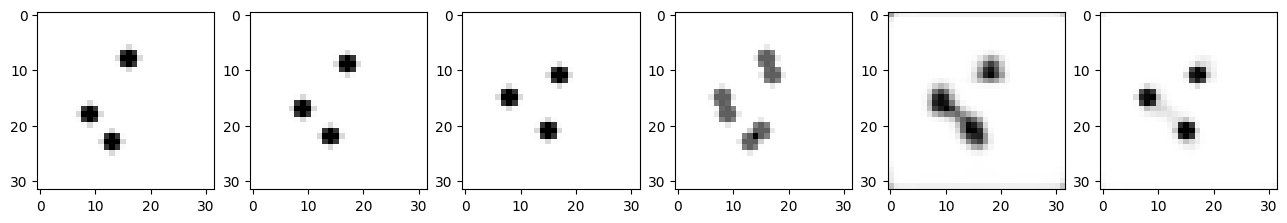

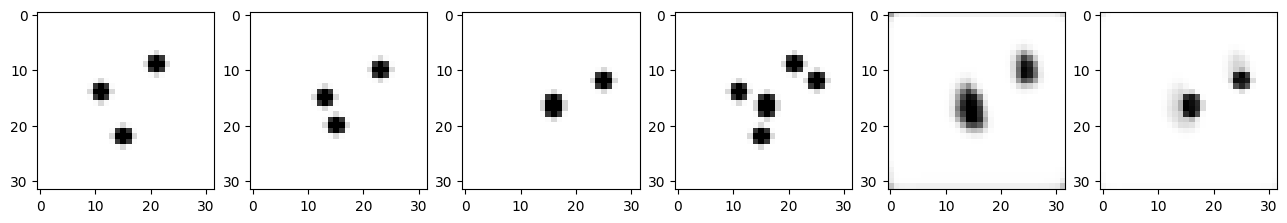

In [8]:
plot_frames(
    model=model,
    x_test=x_test,
    y_test=y_test,
    pixels_per_axis=PIXELS_PER_AXIS,
    colored_balls=COLORED_BALLS,
)

### Coordinates regression

We will try to regress the coordinates of the system (balls position on 2nd frame and velocity vectors) with the activation weights of the bottleneck layer.

In [9]:
encoded_imgs_train = get_encoded_images(
    model=model, data=x_train, layer_name="conv2d_4"
)
encoded_imgs_val = get_encoded_images(model=model, data=x_val, layer_name="conv2d_4")
encoded_imgs_test = get_encoded_images(model=model, data=x_test, layer_name="conv2d_4")
encoded_imgs_train_flat = flatten_encoded_images(encoded_data=encoded_imgs_train)
encoded_imgs_val_flat = flatten_encoded_images(encoded_data=encoded_imgs_val)
encoded_imgs_test_flat = flatten_encoded_images(encoded_data=encoded_imgs_test)

32/32 [==============================] - 0s 12ms/step


### Investigating the activation layers

We have a look at the activation layers to try to understand what is happening inside the neural network.

1/1 [==============================] - 1s 559ms/step
input_1


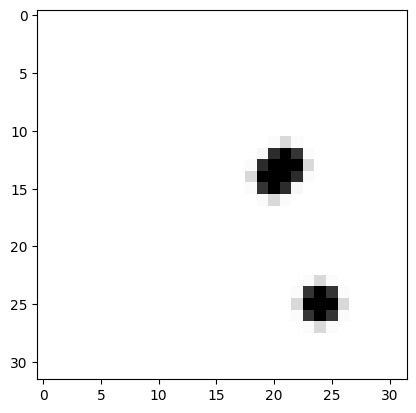

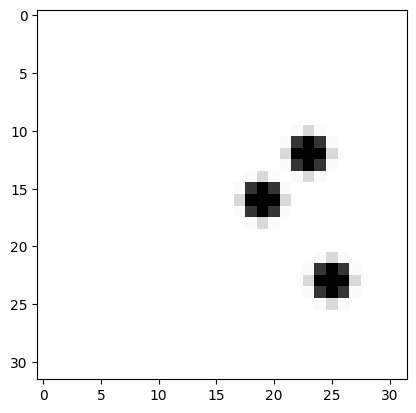

conv2d


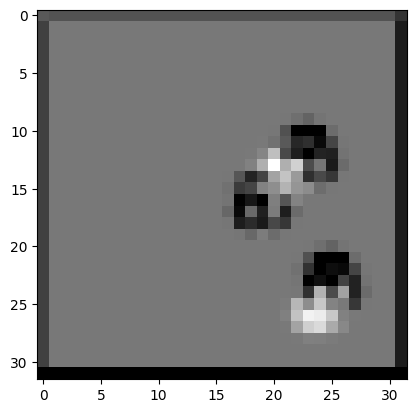

conv2d_1


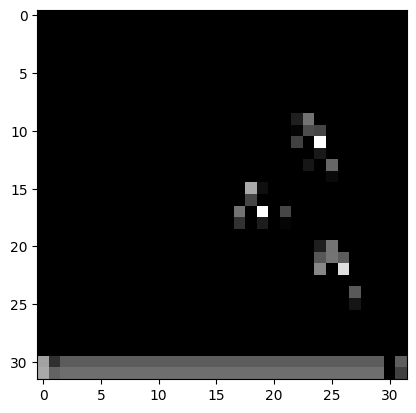

zero_padding2d


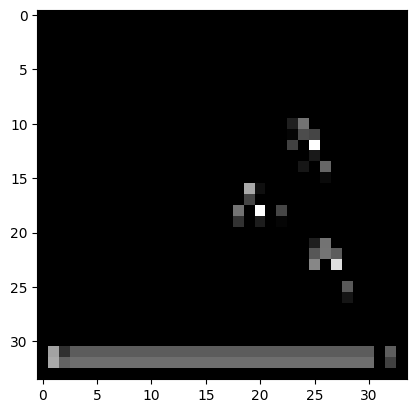

conv2d_2


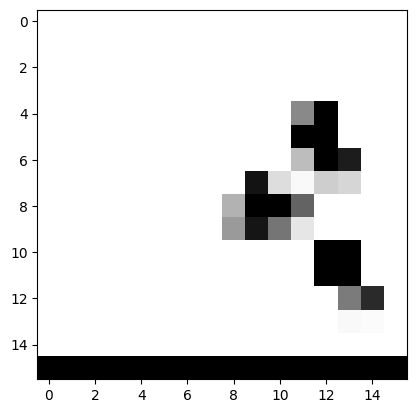

conv2d_3


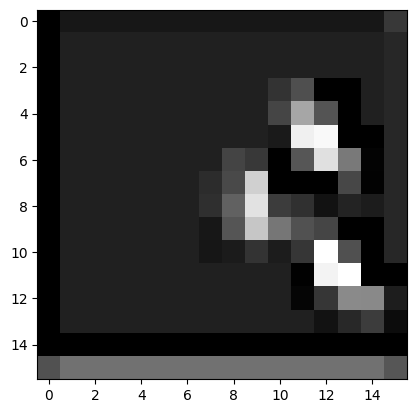

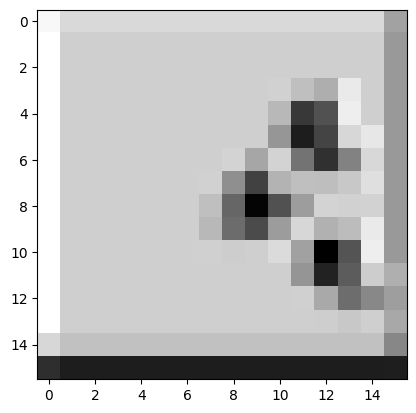

conv2d_4


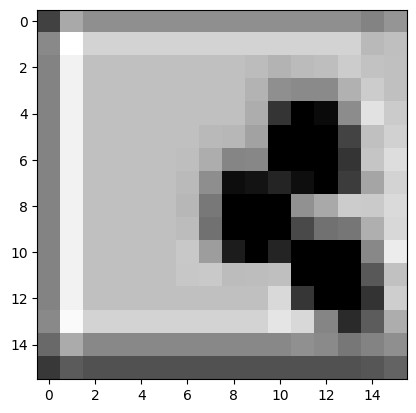

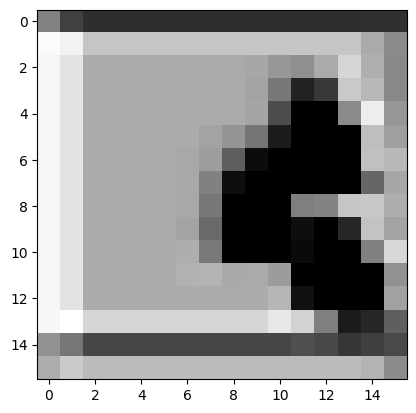

up_sampling2d


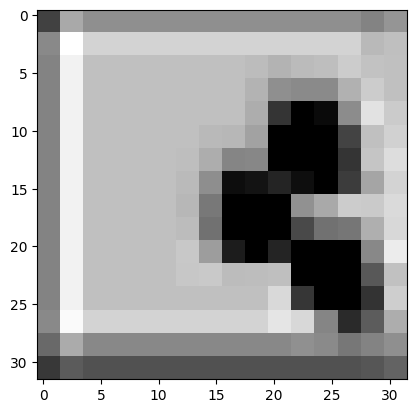

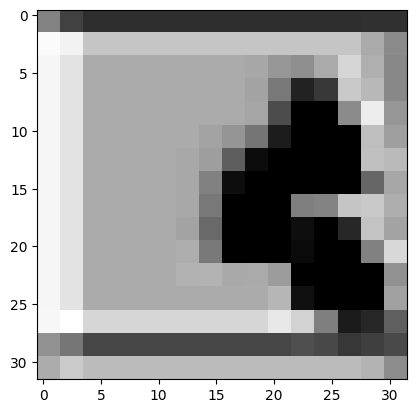

conv2d_5


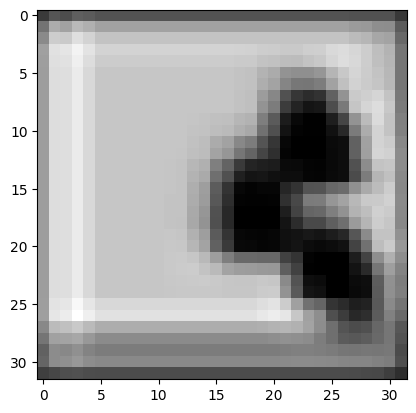

conv2d_6


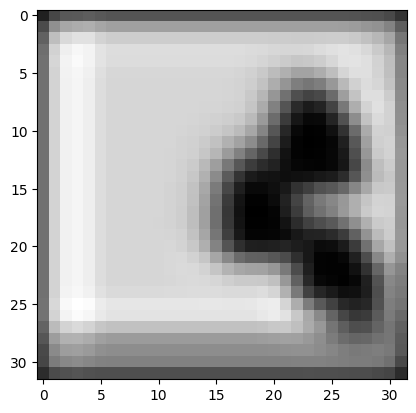

conv2d_7


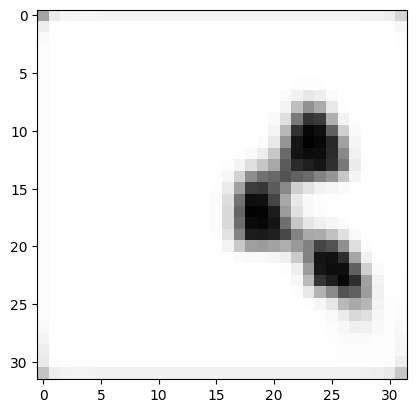

In [10]:
visualize_layer_outputs(model=model, data=x_test, pixels_per_axis=PIXELS_PER_AXIS)

### Coordinates regressor

In [11]:
inputs = Input(shape=(PIXELS_PER_AXIS // 2, PIXELS_PER_AXIS // 2, 2))

x = Conv2D(
    4 * NUM_BALLS, (PIXELS_PER_AXIS // 2, PIXELS_PER_AXIS // 2), activation="relu"
)(inputs)
x = Flatten()(x)

outputs = Dense(4 * NUM_BALLS)(x)

coordinates_regressor = Model(inputs, outputs, name="coordinates_regressor")

coordinates_regressor.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "coordinates_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 12)          6156      
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense (Dense)               (None, 12)                156       
                                                                 
Total params: 6,312
Trainable params: 6,312
Non-trainable params: 0
_________________________________________________________________


In [12]:
coordinates_regressor.compile(optimizer="adam", loss="mse")

coordinates_regressor.fit(
    encoded_imgs_train,
    coordinates_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(encoded_imgs_val, coordinates_val),
    callbacks=[
        EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True, min_delta=0.001
        )
    ],
)

Epoch 1/100
250/250 [==============================] - 3s 7ms/step - loss: 0.1041 - val_loss: 0.0856
Epoch 2/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0887 - val_loss: 0.0857
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.0877 - val_loss: 0.0828
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0860 - val_loss: 0.0830
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0848 - val_loss: 0.0819
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0846 - val_loss: 0.0805
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0837 - val_loss: 0.0812
Epoch 8/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0834 - val_loss: 0.0802
Epoch 9/100
250/250 [==============================] - 1s 4ms/step - loss: 0.0829 - val_loss: 0.0804
Epoch 10/100
250/250 [==============================] - 1s 5ms/step - loss: 0.0826 - val_l

In [13]:
regression_evaluation(
    regressor_model=coordinates_regressor,
    x_test=encoded_imgs_test,
    y_test=coordinates_test,
)

32/32 [==============================] - 0s 1ms/step
Sample 0
Prediction: [0.51912224 0.7983373  0.5207859  0.74460644 0.53884    0.7552269
 0.18616763 0.00082046 0.12079771 0.10183265 0.12167278 0.06744239]
True values: [ 0.38709677  0.74193548  0.74193548  0.80645161  0.5483871   0.58064516
  0.5        -0.25        0.5        -0.5        -0.25        0.5       ]
Sample 1
Prediction: [ 0.5258808   0.53258604  0.52086264  0.53899     0.5176101   0.52633065
  0.01480074  0.02200541  0.00616914 -0.00424464  0.01054461  0.0055673 ]
True values: [ 0.61290323  0.83870968  0.61290323  0.38709677  0.4516129   0.29032258
  0.25       -0.5        -0.5        -0.25       -0.25       -0.5       ]
Sample 2
Prediction: [ 0.46814626  0.49425122  0.45855427  0.45238313  0.47853082  0.4630528
 -0.0444085  -0.04672882 -0.07221759 -0.0680148  -0.08837874  0.00847512]
True values: [ 0.32258065  0.22580645  0.41935484  0.51612903  0.58064516  0.64516129
  0.         -0.5         0.25        0.         -0